In [1]:
# Import libraries
import os
import cv2
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

2023-10-18 10:30:49.312026: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-18 10:30:49.313779: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-18 10:30:49.338019: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-18 10:30:49.338047: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-18 10:30:49.338072: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

In [2]:
# Set directories
root_dir = os.getcwd()
data_dir = os.path.join(root_dir, "mosquitoes-dataset")

In [3]:
IMG_SIZE = (160, 160)

In [5]:
# Load data
train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(data_dir,
                                                               seed=1234,
                                                               validation_split=0.2,
                                                               subset='both',
                                                               batch_size=32,
                                                               image_size=IMG_SIZE,
                                                               )

Found 1201 files belonging to 2 classes.
Using 961 files for training.
Using 240 files for validation.


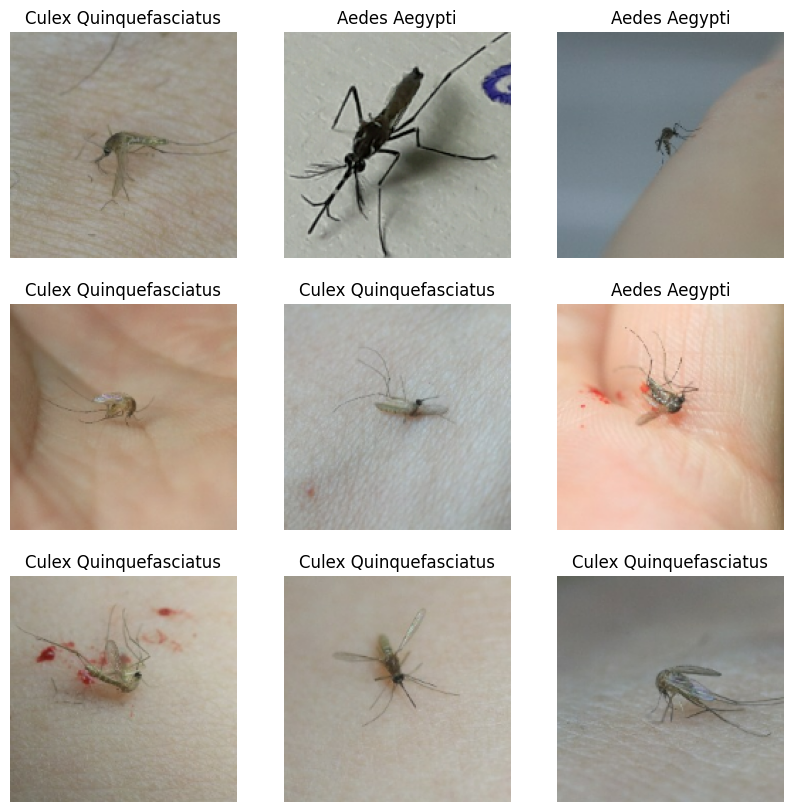

In [6]:
class_names = train_ds.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [7]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 5)
val_ds = val_ds.skip(val_batches // 5)

In [8]:
# Data augmentation
data_augment = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal_and_vertical'),
    tf.keras.layers.RandomRotation(0.2),
])

In [9]:
# Image normalization
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

In [11]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet',
                                               )

In [12]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [13]:
base_model.trainable = False

In [14]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 80, 80, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 80, 80, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 80, 80, 32)           0         ['bn_Conv1[

In [15]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [16]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [17]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augment(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [18]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 160, 160, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 160, 160, 3)       0         
 da)                                                             
                                                                 
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                             

In [19]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0,
                                                       name='accuracy',)],
              )

In [20]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(val_ds)

7/7 [==============================] - 1s 112ms/step - loss: 0.9709 - accuracy: 0.4808


In [21]:
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds,
                    )

Epoch 1/10
31/31 [==============================] - 7s 151ms/step - loss: 0.8634 - accuracy: 0.5276 - val_loss: 0.7578 - val_accuracy: 0.4904
Epoch 2/10
31/31 [==============================] - 7s 202ms/step - loss: 0.7223 - accuracy: 0.5640 - val_loss: 0.7153 - val_accuracy: 0.5337
Epoch 3/10
31/31 [==============================] - 7s 195ms/step - loss: 0.6904 - accuracy: 0.5723 - val_loss: 0.6835 - val_accuracy: 0.5577
Epoch 4/10
31/31 [==============================] - 7s 190ms/step - loss: 0.6539 - accuracy: 0.6223 - val_loss: 0.6544 - val_accuracy: 0.5865
Epoch 5/10
31/31 [==============================] - 7s 189ms/step - loss: 0.6404 - accuracy: 0.6296 - val_loss: 0.6301 - val_accuracy: 0.6538
Epoch 6/10
31/31 [==============================] - 7s 189ms/step - loss: 0.6199 - accuracy: 0.6493 - val_loss: 0.6033 - val_accuracy: 0.6731
Epoch 7/10
31/31 [==============================] - 7s 189ms/step - loss: 0.5957 - accuracy: 0.6795 - val_loss: 0.5784 - val_accuracy: 0.6971
Epoch 

In [22]:
base_model.trainable = True
fine_tune_layers = 120

In [23]:
for layer in base_model.layers[:fine_tune_layers]:
    layer.trainable = False

In [24]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0, name='accuracy')])

In [25]:
len(model.trainable_variables)

38

In [26]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds)


Epoch 10/20
31/31 [==============================] - 11s 248ms/step - loss: 0.4164 - accuracy: 0.8065 - val_loss: 0.3204 - val_accuracy: 0.8606
Epoch 11/20
31/31 [==============================] - 7s 216ms/step - loss: 0.3029 - accuracy: 0.8762 - val_loss: 0.2919 - val_accuracy: 0.8654
Epoch 12/20
31/31 [==============================] - 7s 213ms/step - loss: 0.2657 - accuracy: 0.8907 - val_loss: 0.2574 - val_accuracy: 0.8942
Epoch 13/20
31/31 [==============================] - 7s 212ms/step - loss: 0.2385 - accuracy: 0.9022 - val_loss: 0.1884 - val_accuracy: 0.9471
Epoch 14/20
31/31 [==============================] - 7s 216ms/step - loss: 0.2251 - accuracy: 0.8980 - val_loss: 0.2888 - val_accuracy: 0.8846
Epoch 15/20
31/31 [==============================] - 7s 214ms/step - loss: 0.2313 - accuracy: 0.9126 - val_loss: 0.1750 - val_accuracy: 0.9279
Epoch 16/20
31/31 [==============================] - 7s 213ms/step - loss: 0.2148 - accuracy: 0.9209 - val_loss: 0.1595 - val_accuracy: 0.942

Predictions:
 [0 1 0 1 0 0 1 0 0 1 1 0 1 1 1 1 0 1 0 0 1 0 1 1 1 1 0 1 0 0 0 1]
Labels:
 [0 1 0 1 0 0 1 0 0 1 0 0 1 1 1 1 0 1 0 0 1 0 1 1 0 1 0 1 0 0 0 1]


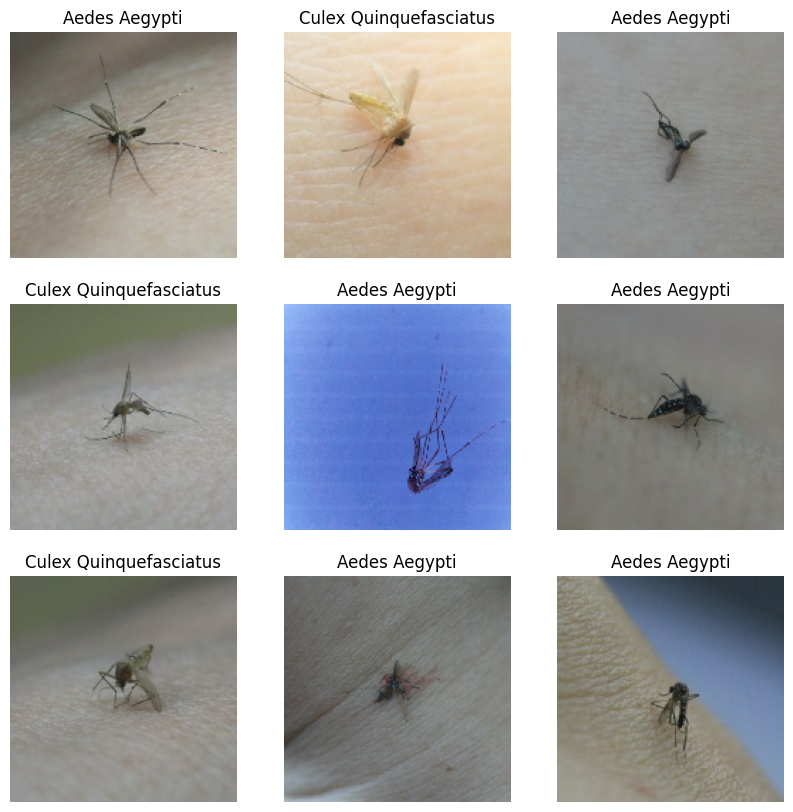

In [27]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype('uint8'))
    plt.title(class_names[predictions[i]])
    plt.axis("off")

1/1 [==============================] - 0s 18ms/step


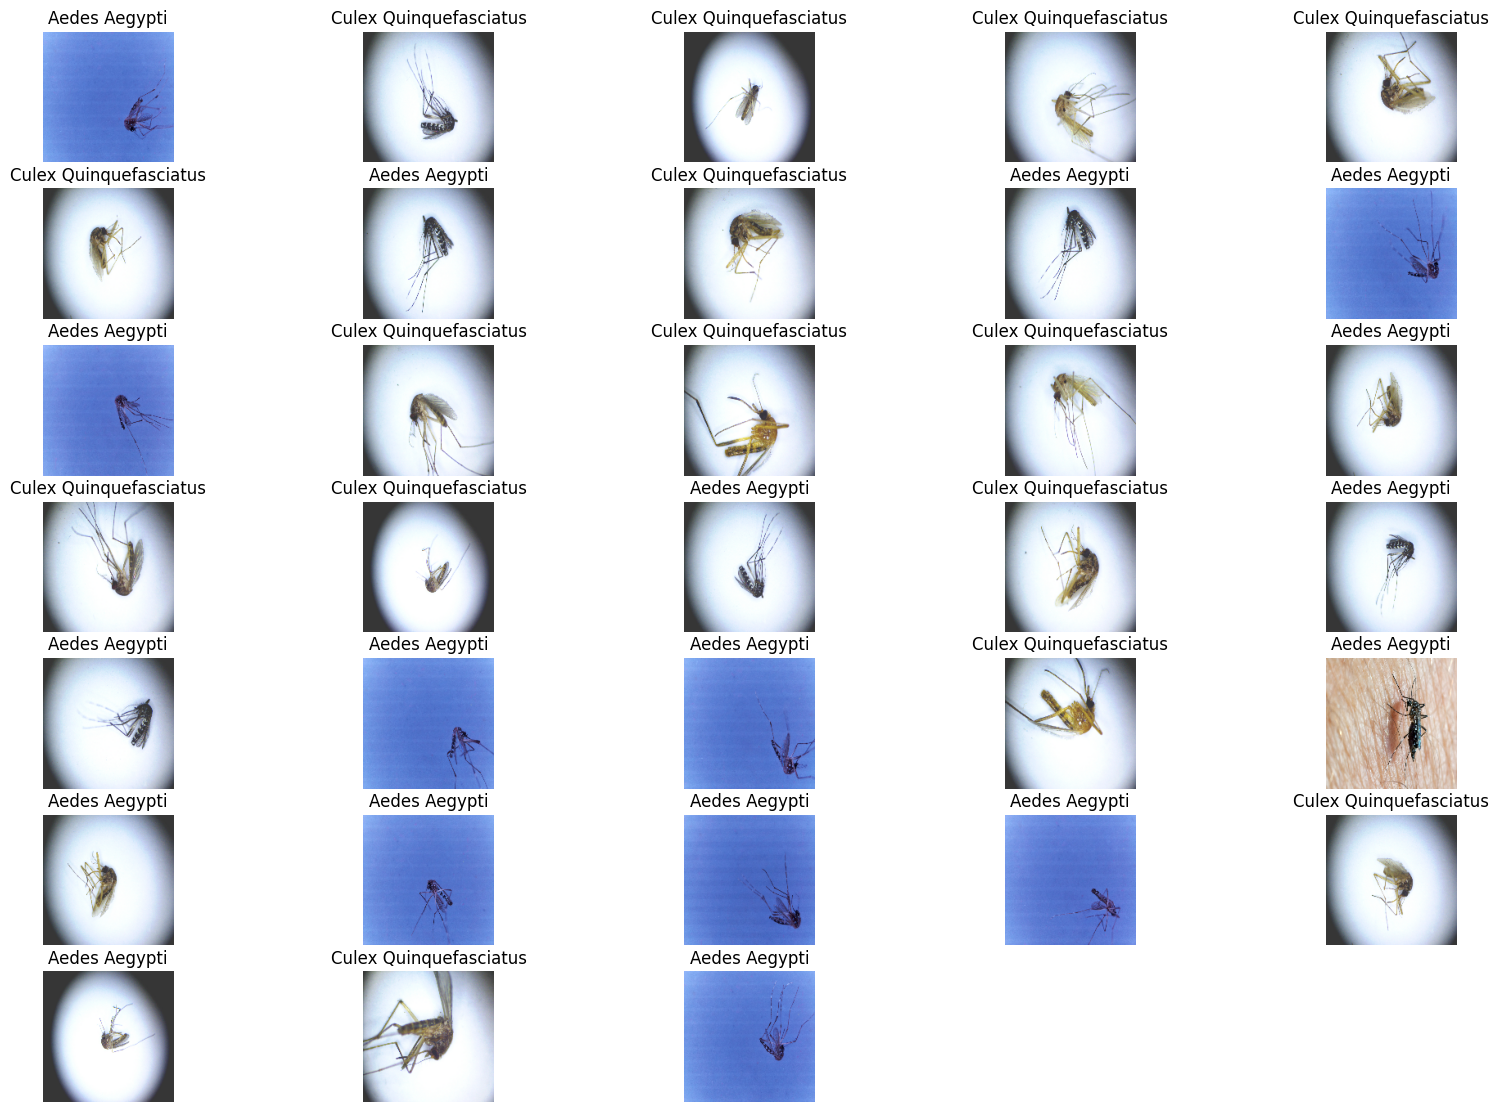

In [28]:
test_dir = os.path.join(root_dir, "test-dataset")

plt.figure(figsize=(20, 20))
for index, image in enumerate(os.listdir(test_dir)):
    img = cv2.imread(os.path.join(test_dir, image))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = tf.image.resize(img, IMG_SIZE)

    yhat = model.predict(np.expand_dims(img, 0))
    yhat = tf.nn.sigmoid(yhat[0])
    yhat = tf.where(yhat < 0.5, 0, 1)
    yhat = np.array(yhat)
    plt.subplot(10, 5, index + 1)
    plt.imshow(img.numpy().astype('uint8'))
    plt.title(class_names[yhat[0]])
    plt.axis("off")

In [29]:
model.save(os.path.join(root_dir, "models", "pretrained_model.keras"))